In [1]:
#import needed libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from time import time
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import ADASYN
sns.set()
%matplotlib inline
import warnings
warning = [DeprecationWarning, FutureWarning, UserWarning]
for w in warning:
    warnings.filterwarnings("ignore", category=w)

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
#Let's look what is the size of the datasets 
print('Train Shape:', train.shape)
print('Test Shape:', test.shape)

Train Shape: (200000, 202)
Test Shape: (200000, 201)


In [4]:
pd.set_option('display.max_columns', None) #display all columns
pd.set_option('display.max_rows', None) #display all rows
train.head(10)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [5]:
# Total number of records
n_records = len(train)

# Number of records where the client made the transaction
made = train.target.sum()

# Number of records where the client didn't make the transaction
didnt_make = n_records - made

# Percentage of transaction made
percentage = made / n_records 

# Print the results
print("Total number of records: {}".format(n_records))
print("Clients that made the transaction: {}".format(made))
print("Clients that didn't make the transaction: {}".format(didnt_make))
print("Percentage of clients that made the transaction: {}%".format(percentage*100))

Total number of records: 200000
Clients that made the transaction: 20098
Clients that didn't make the transaction: 179902
Percentage of clients that made the transaction: 10.049%


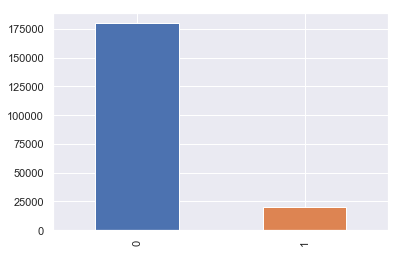

In [6]:
#Plot of distribution of 0 and 1 in the target
train.target.value_counts().plot.bar()

# Preprocessing the data

In [7]:
def drop_columns(dataset):
    columns = ['ID_code', 'target']
    for c in dataset.columns:
        if c in columns:
            dataset = dataset.drop(c, axis = 1)
    return dataset 

In [51]:
y = train['target']
X = drop_columns(train)

In [9]:
#Get a fraction of the data
def stratified_data(data, frac):
    strat_data = data.sample(frac = frac)
    y = strat_data['target']
    X = drop_columns(strat_data)
    return X, y

# Baseline Model

In [22]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [23]:
#Return matrices for XGBoost
def get_xgb_matrix(X_train, X_test, y_train, y_test):
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_test, label=y_test)
    return D_train, D_test

In [24]:
#Creating train, test, split and transforming into XGBoost Matrices
def get_splits(X,y, DMatrix = True):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                      y,
                                      test_size = 0.3,
                                      random_state=0)
    if DMatrix == True:
        D_train, D_test = get_xgb_matrix(X_train, X_test, y_train, y_test)
        return D_train, D_test, y_test
    else:
        return X_train, X_test, y_train, y_test

In [25]:
#Calculate the metrics of the model
def metrics(y_test, predictions, probabilities):
    cm = confusion_matrix(y_test, predictions)
    auc = round(roc_auc_score(y_test, probabilities), 4)
    fpr = round(100 * (cm[0][1]/(cm[0][0]+cm[0][1])))
    tpr = recall_score(y_test, predictions)
    ppv = precision_score(y_test, predictions)
    return cm, auc, fpr, tpr, ppv

In [26]:
#Dealing with imbalance dataset using ADASYN of Imblearn Package
sm = ADASYN(random_state=0, n_jobs = -1)

#### Baseline Model Training

In [27]:
%%time
results = {}
count = 0

X_train, X_test, y_train, y_test = get_splits(X, y, DMatrix= False)

X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

baseline_model = LogisticRegressionCV(cv = 2, penalty= 'l2', n_jobs=-1)
baseline_model.fit(X_train, y_train)

pred = baseline_model.predict(X_test)
proba = baseline_model.predict_proba(X_test)[:,1]

cm, auc, fpr, tpr, ppv = metrics(y_test, pred, proba)   
results[count] = {"TN": cm[0][0],
                  "FP": cm[0][1],
                  "FN": cm[1][0],
                  "TP": cm[1][1],
                  "AUC": auc,
                  "FPR": fpr,
                  "TPR": tpr,
                  "PPV": ppv
                 }
print("Done.")
sys.stdout.flush()

Done.
Wall time: 9.58 s


In [28]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results = pd.DataFrame(results).T[cols]
df_results

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,10600.0,163.0,931.0,306.0,2.0,0.247373,0.652452,0.857


In [29]:
print("AUC Result: %", round(df_results.AUC.mean(),4))
print("FPR Result: %", round(df_results.FPR.mean(),4))
print("Recall Result: %", round(df_results.TPR.mean(),4))
print("Precision Result: %", round(df_results.PPV.mean(),4))

AUC Result: % 0.857
FPR Result: % 2.0
Recall Result: % 0.2474
Precision Result: % 0.6525


# XGBoost Model

In [30]:
#Training XGBoost model function
def model_training(dtrain, params, rounds):
    model = xgb.train(dtrain= dtrain, params= params, num_boost_round= rounds)
    return model

In [31]:
#make predictions based on probabilities and a threshold
def get_preds(probabilities, threshold):
    return np.array([1 if x > threshold else 0 for x in probabilities])

## Hyperparameters Optimization

In [32]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

X, y = stratified_data(train, 0.2)

D_train, D_test, y_test = get_splits(X,y, DMatrix=True)

def objective(space):
    # Instantiate the classifier
    params = {'objective': space['objective'],
          'colsample_bytree': space['colsample_bytree'], 
          'gamma': space['gamma'],
          'learning_rate': space['learning_rate'],
          'max_depth': int(space['max_depth']), 
          'min_child_weight': space['min_child_weight'], 
          'reg_alpha': space['reg_alpha'], 
          'scale_pos_weight': space['scale_pos_weight'], 
          'subsample': space['subsample'],
          'tree_method': space['tree_method'],
          'silent': space['silent']
         }
    
    model = model_training(D_train, params, 5000)

    # Predict probabilities on training set
    probas = model.predict(D_test)
    
    # Calculate our Metric - AUC on testing set
    auc = roc_auc_score(y_test, probas)

    # return loss function.
    return {'loss': -auc, 'status': STATUS_OK }

In [33]:
space ={'max_depth': hp.quniform("max_depth", 2, 6, 1),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
        'learning_rate': hp.quniform ('learning_rate', 0.01, 0.3, 0.01),
        'subsample': hp.quniform ('subsample', 0.7, 1., 0.01),
        'gamma' : hp.quniform ('gamma', 1,10,1),
        'reg_alpha' : hp.quniform ('reg_alpha', 0.1,1.0,0.05),
        'colsample_bytree' : hp.quniform ('colsample_bytree', 0.01,1,0.01),
        'scale_pos_weight' : hp.quniform('scale_pos_weight', 1,10,0.05),
        'objective': "binary:logistic",
        'tree_method': 'gpu_hist',
        'silent': 1
    }

In [34]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=1000,
            trials=trials)
print(best)

100%|████████████████████████████████████████████| 1000/1000 [5:09:47<00:00, 17.04s/it, best loss: -0.8930107242887756]
{'colsample_bytree': 0.04, 'gamma': 1.0, 'learning_rate': 0.03, 'max_depth': 2.0, 'min_child_weight': 9.0, 'reg_alpha': 0.9500000000000001, 'scale_pos_weight': 1.2000000000000002, 'subsample': 0.81}


In [35]:
#Getting the best hyperparameters 
def get_best_hyperparameters(best):
    hyperparameters = {'colsample_bytree': 0.06, 
                   'gamma': 6.0,
                   'learning_rate': 0.26,
                   'max_depth': 4,
                   'min_child_weight': 10.0,
                   'reg_alpha': 0.75,
                   'scale_pos_weight': 6.25,
                   'subsample': 0.98,
                   'objective': "binary:logistic",
                   'tree_method': 'gpu_hist',
                   'silent': 1
                  }
    hyperparameters.update(best)
    hyperparameters['max_depth'] = int(hyperparameters['max_depth'])
    return hyperparameters

## Training and Validation

In [36]:
#Setting up RepeatedStratifiedKFold
splits = 4
repeats = 2
iterations = splits * repeats
rskf = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=0)

In [52]:
%%time

results_xgb = {}
count = 0

#X, y = stratified_data(train, 0.4)

for train_index, test_index in rskf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
      
    D_train, D_test = get_xgb_matrix(X_train, X_test, y_train, y_test)
    
    xgbmodel = model_training(D_train, get_best_hyperparameters(best), 5000)
    
    probas = xgbmodel.predict(D_test)

    preds = get_preds(probas, 0.5)
   
    cm, auc, fpr, tpr, ppv = metrics(y_test, preds, probas)   
    results_xgb[count] = {"TN": cm[0][0],
                      "FP": cm[0][1],
                      "FN": cm[1][0],
                      "TP": cm[1][1],
                      "AUC": auc,
                      "FPR": fpr,
                      "TPR": tpr,
                      "PPV": ppv
                     }
    count += 1
    print("\rTraining. {}/{}".format(count,iterations), end=" ")
    sys.stdout.flush()

Training. 8/8        Wall time: 4min 6s


In [53]:
cols = ["TN", "FP", "FN","TP","FPR","TPR","PPV","AUC"]
df_results_xgb = pd.DataFrame(results_xgb).T[cols]
df_results_xgb

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
0,44432.0,544.0,3284.0,1741.0,1.0,0.346468,0.761926,0.8990
1,44454.0,522.0,3320.0,1705.0,1.0,0.339303,0.765604,0.8983
2,44473.0,502.0,3268.0,1756.0,1.0,0.349522,0.777679,0.8984
3,44474.0,501.0,3285.0,1739.0,1.0,0.346139,0.776339,0.8957
4,44517.0,459.0,3301.0,1724.0,1.0,0.343085,0.789739,0.9020
5,44454.0,522.0,3323.0,1702.0,1.0,0.338706,0.765288,0.8974
6,44438.0,537.0,3260.0,1764.0,1.0,0.351115,0.766623,0.8959
7,44463.0,512.0,3297.0,1727.0,1.0,0.343750,0.771326,0.8952


In [54]:
df_results_xgb.describe()

,TN,FP,FN,TP,FPR,TPR,PPV,AUC
count,8.000000,8.000000,8.000000,8.000000,8.0,8.000000,8.000000,8.000000
mean,44463.125000,512.375000,3292.250000,1732.250000,1.0,0.344761,0.771816,0.897738
std,26.416648,26.397714,22.562611,22.192341,0.0,0.004442,0.009121,0.002223
min,44432.000000,459.000000,3260.000000,1702.000000,1.0,0.338706,0.761926,0.895200
25%,44450.000000,501.750000,3280.000000,1719.250000,1.0,0.342139,0.765525,0.895850
50%,44458.500000,517.000000,3291.000000,1733.000000,1.0,0.344944,0.768975,0.897850
75%,44473.250000,525.750000,3305.750000,1744.750000,1.0,0.347231,0.776674,0.898550
max,44517.000000,544.000000,3323.000000,1764.000000,1.0,0.351115,0.789739,0.902000


numpy.ndarray

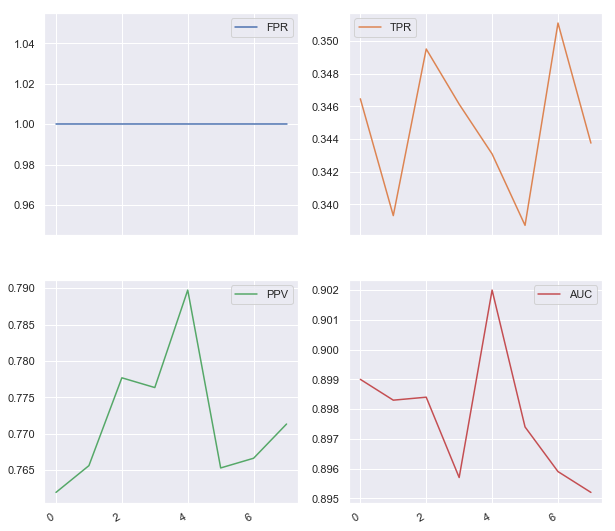

In [55]:
axes = df_results_xgb[["FPR","TPR","PPV","AUC"]].plot(subplots=True, layout=(2,2), figsize = (10,10))
type(axes)

In [56]:
print("Average AUC Result: %", round(df_results_xgb.AUC.mean(),4))
print("Average FPR Result: %", round(df_results_xgb.FPR.mean(),4))
print("Average TPR Result: %", round(df_results_xgb.TPR.mean(),4))
print("Average PPV Result: %", round(df_results_xgb.PPV.mean(),4))

Average AUC Result: % 0.8977
Average FPR Result: % 1.0
Average TPR Result: % 0.3448
Average PPV Result: % 0.7718


## Feature Importances

In [57]:
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
ceate_feature_map(X)

In [58]:
def itemgetter(*items):
    if len(items) == 1:
        item = items[0]
        def g(obj):
            return obj[item]
    else:
        def g(obj):
            return tuple(obj[item] for item in items)
    return g

In [59]:
importance = xgbmodel.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore_ratio'] = df['fscore'] / df['fscore'].sum()
feat_imp = df.sort_values(by=['fscore'],ascending=False )
feat_imp.head(10)

,feature,fscore,fscore_ratio
199,var_22,151,0.010067
198,var_13,144,0.009600
197,var_174,143,0.009533
196,var_108,139,0.009267
195,var_78,138,0.009200
194,var_190,138,0.009200
190,var_34,137,0.009133
193,var_92,137,0.009133
192,var_133,137,0.009133
191,var_6,137,0.009133


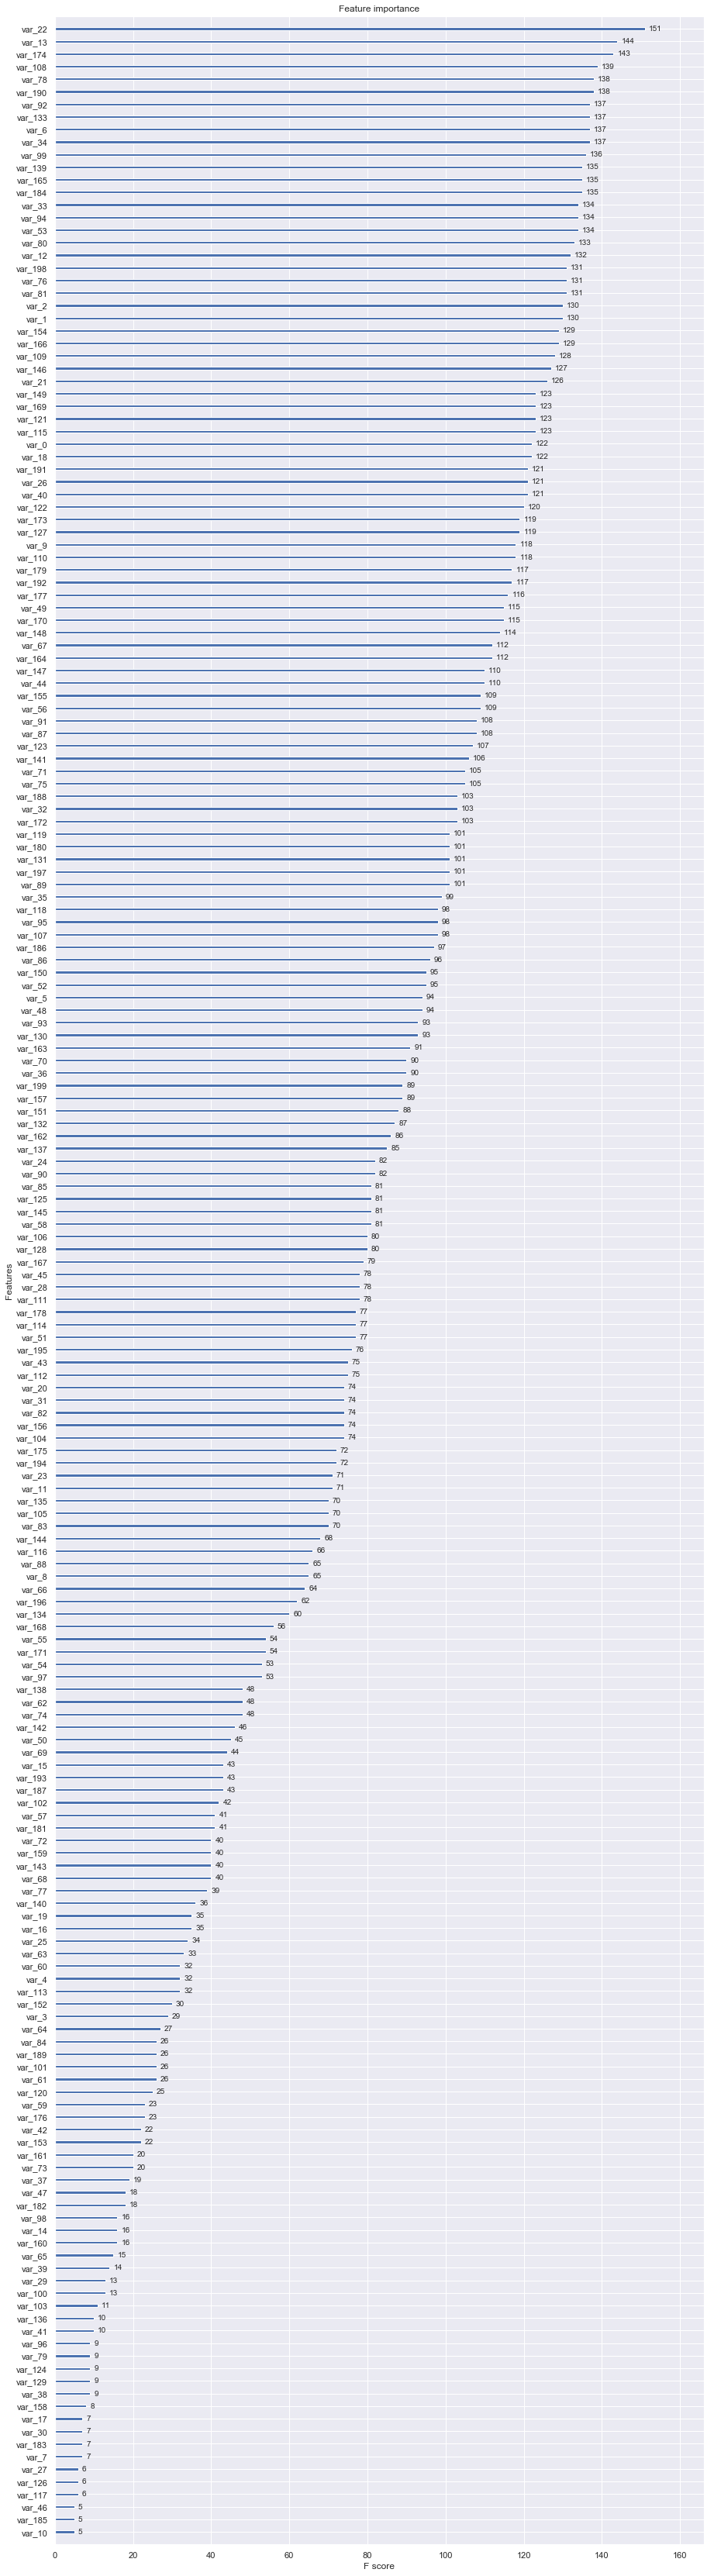

In [60]:
def my_plot_importance(booster, figsize, **kwargs): 
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)
my_plot_importance(xgbmodel, (15,60))

## Model ROC Curve

In [61]:
roc_values = []
for thresh in np.linspace(0, 1, 101):
    preds = get_preds(probas, thresh)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

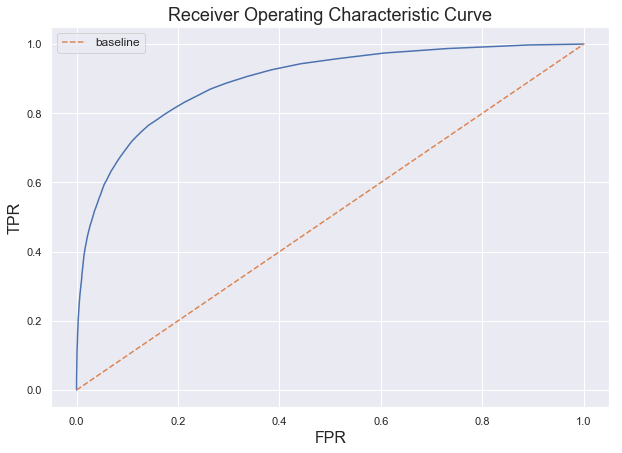

In [62]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

# Submission

In [63]:
def transform_data(data):
    data = drop_columns(data)
    dtest = xgb.DMatrix(data)
    return dtest

In [64]:
def make_csv(d_test, model):
    preds_final = model.predict(d_test)
    predictions = pd.Series(preds_final, index = test['ID_code'], name = 'target')
    return predictions.to_csv("submission.csv", header = True)

In [65]:
d_test = transform_data(test)
make_csv(d_test, xgbmodel)

### Submission Score: **0.89599** Leaderboard ~5183